# Initial Model Report

**PROJECT GOAL:** Can a web users’ purchase intensions be predicted through their browsing behaviors?

In [4]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 100)
df = pd.read_csv('./data/online_shoppers_intention.csv')


# Background 

Early understanding of the data is critical in regards to model interpretation. The original dataset contained 18 columns and 12330 rows. The target variable, "Revenue" was heavily skewed, with only 15.5% of web users making a purchase during that visit. 

After observing the target variable, we dove into specific variables to observe how the distribution of each may affect our models.
For instance, the website was visited far more frequently during the week (M-F) and by returning visitors. It was also noteable that "region 1" was by far the most popular location for visitors.

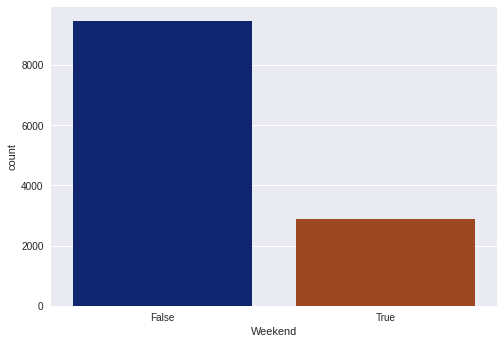

In [ ]:
sns.countplot(df['Weekend'], palette='dark')

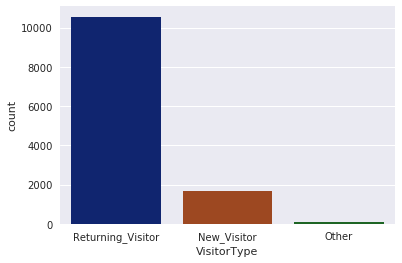

In [ ]:
sns.countplot(df['VisitorType'], palette='dark')

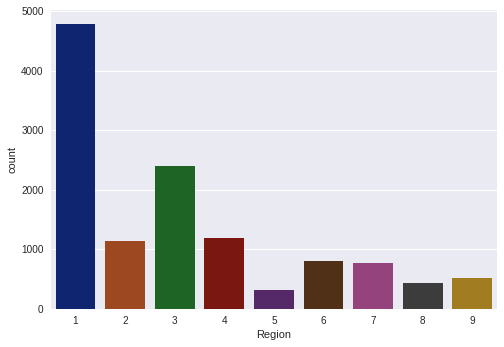

In [ ]:
sns.countplot(df['Region'], palette='dark')

We then decided to run crosstab visualizations to see how certain variables compared to the target value.

It was determined that most of the website's purchases (as well as non-purchasing visits) occured in November, followed closely by May and March. This was interpreted as sales revolving around holiday times. This idea is plausable due to the high non-purchase rate in December, which could be caused by customers visiting the site to browse for gifts, but not making a purchase. Similarly, the website's highest reported Bounce and ExitRates also occured within those three months.

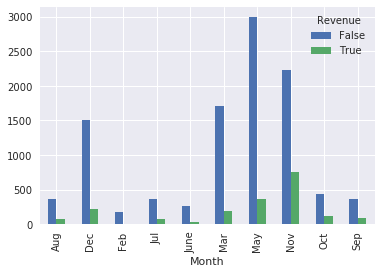

In [ ]:
pd.crosstab(df['Month'],df['Revenue']).plot.bar()

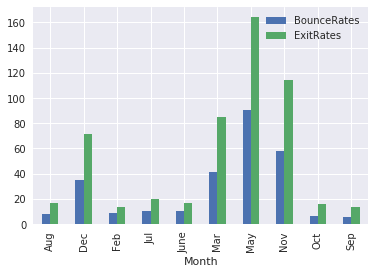

In [ ]:
df.groupby(['Month'])['BounceRates','ExitRates'].sum().plot(kind ="bar")

We also noted that returning_visitors had the highest rate of non-purchases out of all the visitors. This could be explained by returning customers checking the site periodically to check for sales or specific prices. While new visitors also had a higher rate of non-purchasing, it could be inferred that as a new customer, they were referred to or sought out the website to find a specific product, not to casually browse for deals.

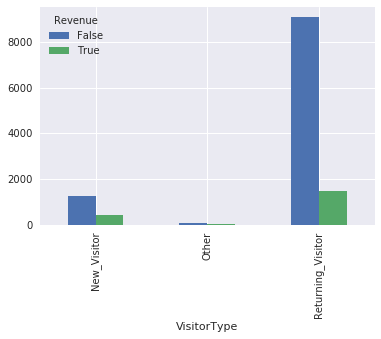

In [ ]:
pd.crosstab(df['VisitorType'],df['Revenue']).plot.bar()

After observing the high occurance of region_1, we decided to see if this website's revenue also heavily flowed from the same region. However, while region_1 is more profitable than the others, it also supported the highest rate of non-purchasing visits, approximately double the amount as the second most popular region, region_3. We observed a similar pattern when grouping by Bounce and Exit Rates, with region_1 leading in both accounts.

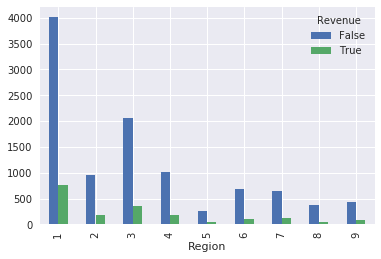

In [ ]:
pd.crosstab(df['Region'],df['Revenue']).plot.bar()

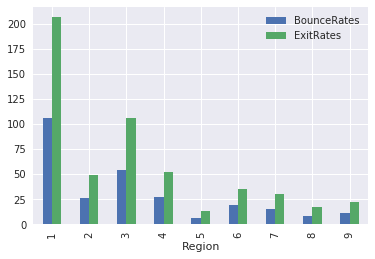

In [ ]:
df.groupby(['Region'])['BounceRates','ExitRates'].sum().plot(kind ="bar")

Finally, we wanted to measure Bounce and ExitRates against our target feature. It appears that even visitors that make a purchase on the site experience a moderate ExitRate. This could be attributed to the 

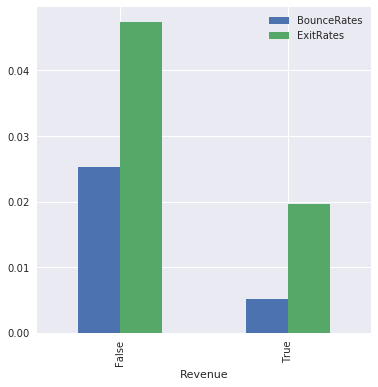

In [ ]:
(df.groupby(["Revenue"])['BounceRates','ExitRates'].agg('mean')).plot.bar(figsize = (6,6))

In [ ]:
#Install all dependencies needed by running the code below.
%run ./system_check.ipynb

Requirement already up-to-date: imbalanced-learn in /home/jupyter-evincent/.local/lib/python3.6/site-packages (0.6.2)


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Farisalenezy/BA-545-Project-2/master/data/online_shoppers_intention.csv?token=ANCJ6SXT5LT7KWO6T5BAVFK6TZIUY')
df.head().T


,0,1,2,3,4
Administrative,0,0,0,0,0
Administrative_Duration,0,0,0,0,0
Informational,0,0,0,0,0
Informational_Duration,0,0,0,0,0
ProductRelated,1,2,1,2,10
ProductRelated_Duration,0,64,0,2.66667,627.5
BounceRates,0.2,0,0.2,0.05,0.02
ExitRates,0.2,0.1,0.2,0.14,0.05
PageValues,0,0,0,0,0
SpecialDay,0,0,0,0,0


In [ ]:
df.shape

(12330, 18)

### Imputation of Missing Values

In [ ]:
# source: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
# a function that provides a summary of the  missing values in a dataset

def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(df)

Your selected dataframe has 18 columns and 12330 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [ ]:
df.describe().round(5).T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.31517,3.32178,0.0,0.00000,1.00000,4.00000,27.00000
Administrative_Duration,12330.0,80.81861,176.77911,0.0,0.00000,7.50000,93.25625,3398.75000
Informational,12330.0,0.50357,1.27016,0.0,0.00000,0.00000,0.00000,24.00000
Informational_Duration,12330.0,34.47240,140.74929,0.0,0.00000,0.00000,0.00000,2549.37500
ProductRelated,12330.0,31.73147,44.47550,0.0,7.00000,18.00000,38.00000,705.00000
ProductRelated_Duration,12330.0,1194.74622,1913.66929,0.0,184.13750,598.93690,1464.15721,63973.52223
BounceRates,12330.0,0.02219,0.04849,0.0,0.00000,0.00311,0.01681,0.20000
ExitRates,12330.0,0.04307,0.04860,0.0,0.01429,0.02516,0.05000,0.20000
PageValues,12330.0,5.88926,18.56844,0.0,0.00000,0.00000,0.00000,361.76374
SpecialDay,12330.0,0.06143,0.19892,0.0,0.00000,0.00000,0.00000,1.00000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12330 non-null int64
Administrative_Duration    12330 non-null float64
Informational              12330 non-null int64
Informational_Duration     12330 non-null float64
ProductRelated             12330 non-null int64
ProductRelated_Duration    12330 non-null float64
BounceRates                12330 non-null float64
ExitRates                  12330 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes: bool(

In [ ]:
df["average_informational_duration"] = df['Informational_Duration']/df['Informational']
df["average_administrative_duration"] = df['Administrative_Duration']/df['Administrative']
df["average_ProductRelated_duration"] = df['ProductRelated_Duration']/df['ProductRelated']
df["average_BounceRates/ExitRates"] = (df["BounceRates"]+df["ExitRates"])/2
df.isna().sum()
df = df.fillna(0)
df.isna().sum()


Administrative                     0
Administrative_Duration            0
Informational                      0
Informational_Duration             0
ProductRelated                     0
ProductRelated_Duration            0
BounceRates                        0
ExitRates                          0
PageValues                         0
SpecialDay                         0
Month                              0
OperatingSystems                   0
Browser                            0
Region                             0
TrafficType                        0
VisitorType                        0
Weekend                            0
Revenue                            0
average_informational_duration     0
average_administrative_duration    0
average_ProductRelated_duration    0
average_BounceRates/ExitRates      0
dtype: int64

In [ ]:


months = {'JAN':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5,
     'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10,
     'Nov':11, 'Dec':12}

df['months'] = df.Month.map(months)
df['months'].value_counts()
seasons = ((df['months'] % 12 + 3) // 3).map({1:'winter', 2: 'Spring', 3:'summer', 4:'Fall'})
df["season"]= seasons
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType,VisitorType,Weekend,Revenue,average_informational_duration,average_administrative_duration,average_ProductRelated_duration,average_BounceRates/ExitRates,months,season
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,1,Returning_Visitor,False,False,0.0,0.000000,0.000000,0.200000,2,winter
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,2,Returning_Visitor,False,False,0.0,0.000000,32.000000,0.050000,2,winter
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,3,Returning_Visitor,False,False,0.0,0.000000,0.000000,0.200000,2,winter
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,4,Returning_Visitor,False,False,0.0,0.000000,1.333333,0.095000,2,winter
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,4,Returning_Visitor,True,False,0.0,0.000000,62.750000,0.035000,2,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,1,Returning_Visitor,True,False,0.0,48.333333,33.656447,0.018087,12,winter
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,8,Returning_Visitor,True,False,0.0,0.000000,93.150000,0.010667,11,Fall
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,13,Returning_Visitor,True,False,0.0,0.000000,30.708333,0.085000,11,Fall
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,11,Returning_Visitor,False,False,0.0,18.750000,23.066667,0.010526,11,Fall


In [ ]:



dummy = [
 
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType',
'VisitorType' ,
    'season'
 ]

for i  in dummy:
    df[i+'_dummies'] =df[i]
#list(df.columns)
dummies_cols = [
 'OperatingSystems_dummies',
 'Browser_dummies',
 'Region_dummies',
 'TrafficType_dummies',
 'VisitorType_dummies',
 'season_dummies'
]
df= pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=dummies_cols,sparse=False, drop_first=False, dtype=None)
df['Weekend_binary'] = df['Weekend'].map({True:1,False:0})
df['Revenue_Y'] = df['Revenue'].map({True:1,False:0})



list of correlation pair (Max on top):
BounceRates     ExitRates                  0.913004
ProductRelated  ProductRelated_Duration    0.860927
Informational   Informational_Duration     0.618955
Administrative  Administrative_Duration    0.601583
dtype: float64
--------------------------


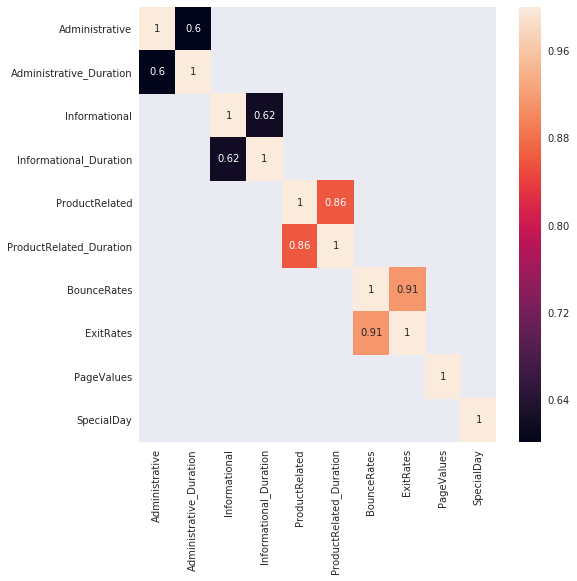

In [ ]:
corr_cols =['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
           
 ]


# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
#correlation matrix
corr_matrix = df[corr_cols].corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
corr_list = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
## prints a descending list of correlation pair (Max on top)
print('list of correlation pair (Max on top):')
print(corr_list[corr_list>= .5])
print("--------------------------")


corr_df =df[corr_cols].corr().abs()
corr_df = corr_df[corr_df >= .5]           
plt.figure(figsize= (8,8))
corr = corr_df#.round(4)
sns.heatmap(corr, annot=True)
plt.show()

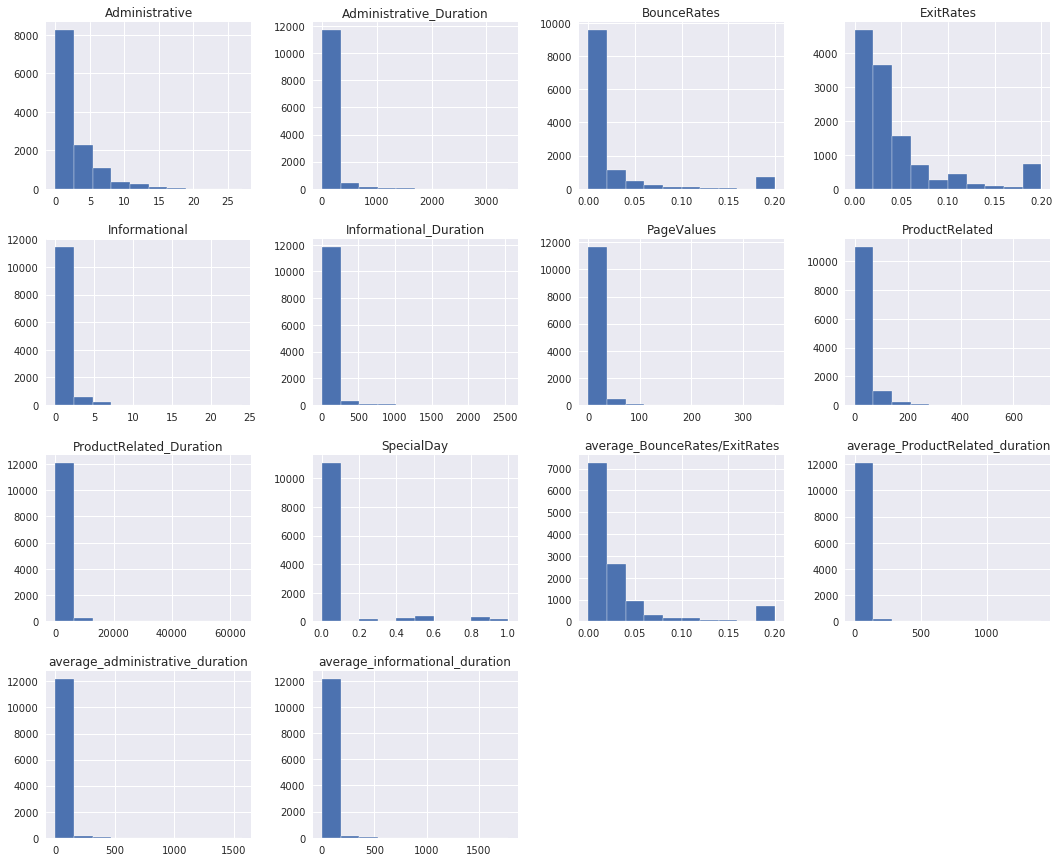

In [ ]:
cols =['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
    'average_informational_duration', 
                'average_administrative_duration',
       'average_ProductRelated_duration', 'average_BounceRates/ExitRates' ,
 ]
#df[cols].hist( figsize = (35,20))

#fig, ax = plt.subplots(len(cols), figsize=(40,40))
"""df[cols].hist
#fig, ax = plt.subplots(len(cols), figsize=(10, 5))
for col_val in cols:
    
    df[col_val].plot(kind = 'hist' , title = col_val )
    #ax1.set(xlabel='Original ' + col_val)
    
    #df[col_val].hist(    color='#86bf91')

    plt.show()"""

df[cols].hist(figsize =(18,15))
plt.show()

### Determining How to Handle Outliers

Before determing what to do with outliers, we decided to look at a few scatter plots of data to get an idea of the data in relation to PageValues, the driving force leading to revenue. The scatter plots are colored based on if the data point resulted in revenue or not. These two visualizations are two we selected for the purpose of showing two examples, if you would like to referance any more you can look at the Visualization.ipynb file to see more.

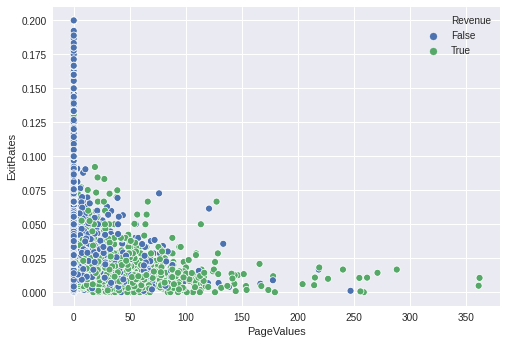

In [ ]:
sns.scatterplot(x='PageValues', y='ExitRates', hue = 'Revenue', data=df) 

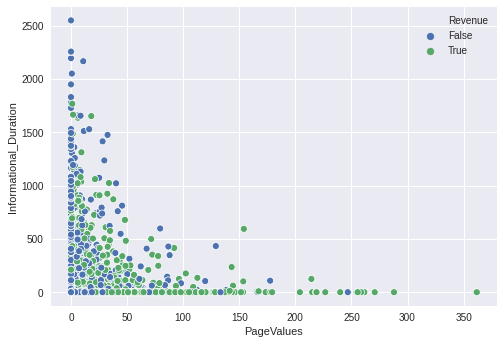

In [ ]:
sns.scatterplot(x='PageValues', y='Informational_Duration',hue = 'Revenue', data=df)

When looking at the two example visualziations above, it can be seen that it is the outliers that are causing the skewness in the data. 

You can see specifically wih ExitRates in the first visualization, no revenue accrue with 0 value for PageValue. Because of this, esentially we know that there is a large amount of people that come onto the site, and choose to leave right away. Within the distribution of the data, it will create a skewnewss, however it essentially impacts the results the same way.

In the second visualization, for 0 value PageValues there are no instances of Informational Duration. There are some instances of what apears to be in the low single digits of a higher Information Duration, but for the most part this seems to be the same as the first visualization. Within the distribution of the data, it will create a skewnewss, however it essentially impacts the results the same way.

Rather than dropping these datapoints, we have determined to keep them in the data set to be used in our models because they directly effect the shape of the distribution which is relevant to how we standardize and normalize it.


### Handling Skewness


 ------------------------------------------------------

 'PageValues_skew' had 'positive' skewness of 6.38

 Transformation yielded skewness of 1.34


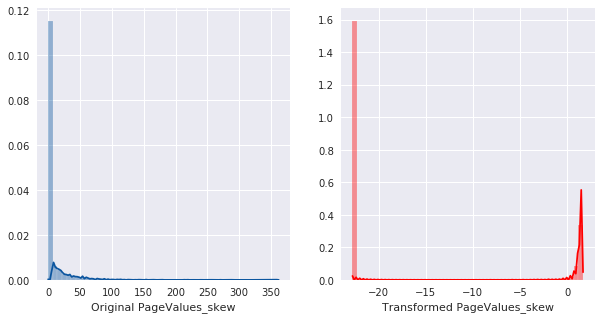


 ------------------------------------------------------

 'Informational_Duration_skew' had 'positive' skewness of 7.58

 Transformation yielded skewness of 1.54


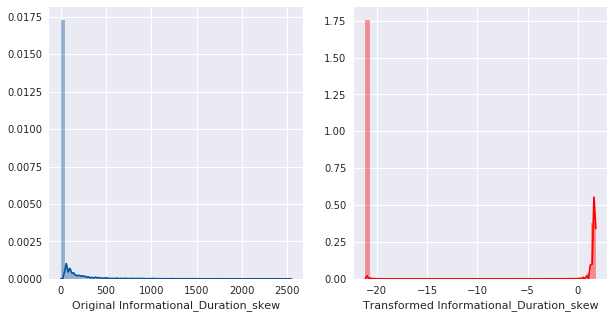


 ------------------------------------------------------

 'average_informational_duration_skew' had 'positive' skewness of 11.22

 Transformation yielded skewness of 1.54


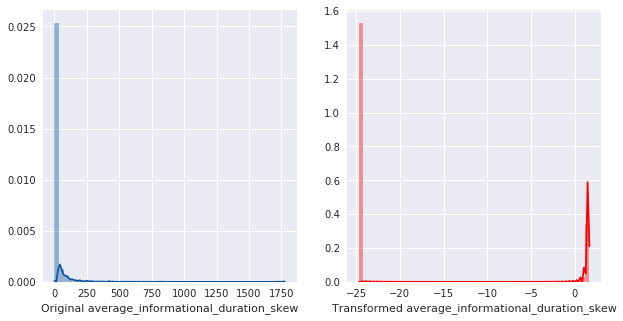


 ------------------------------------------------------

 'average_administrative_duration_skew' had 'positive' skewness of 9.42

 Transformation yielded skewness of -0.00


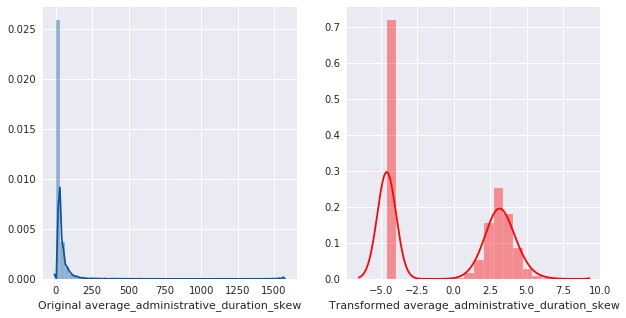


 ------------------------------------------------------

 'average_ProductRelated_duration_skew' had 'positive' skewness of 10.30

 Transformation yielded skewness of 0.21


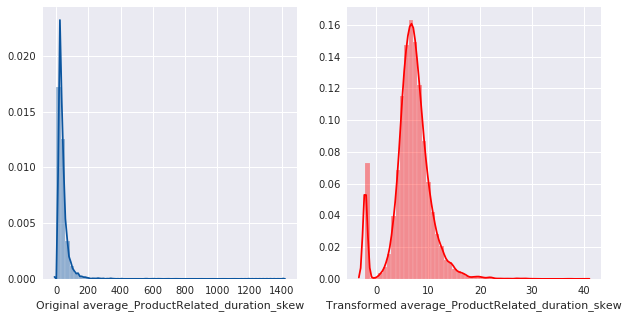


 ------------------------------------------------------

 'average_BounceRates/ExitRates_skew' had 'positive' skewness of 2.66

 Transformation yielded skewness of 0.11


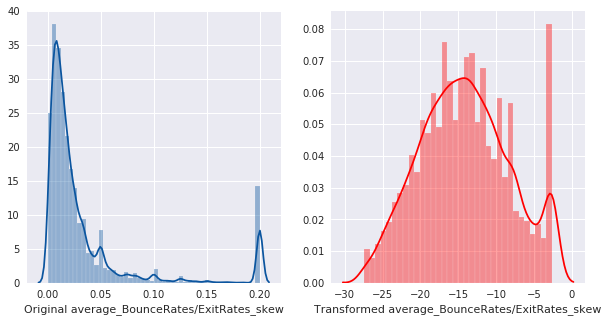

In [ ]:
from skew_autotransform import skew_autotransform
skew_cols = [

 
 
 'PageValues',
 
   'Informational_Duration'  , 'average_informational_duration', 'average_administrative_duration',
       'average_ProductRelated_duration',        'average_BounceRates/ExitRates'
            ]

 
for i  in skew_cols:

    df[i+'_skew'] = df[i]
    
    
cols_to_skew = [

 
 
 'PageValues_skew' ,
 
  'Informational_Duration_skew' ,
                
                'average_informational_duration_skew', 
                'average_administrative_duration_skew',
       'average_ProductRelated_duration_skew',
                'average_BounceRates/ExitRates_skew'
               
               
               
               ]

df = skew_autotransform(df,include = cols_to_skew, plot = True, exp = False, threshold = 0.01)


**As can be seen in the above visualizations, there was a tendency for a right skewness in most features prior to normalization.**

In [ ]:
cols_skew = [
'PageValues_skew'   ,   'average_informational_duration_skew', 
                'average_administrative_duration_skew',
       'average_ProductRelated_duration_skew',  'average_BounceRates/ExitRates_skew']
df[cols_skew].skew()

### Standardization

We then use MinMaxScaler to apply standardization to the data. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler , StandardScaler

min_max_col_pre = [  
                   
                  
       'PageValues_skew',   'average_informational_duration_skew', 
                'average_administrative_duration_skew',
       'average_ProductRelated_duration_skew' , 'average_BounceRates/ExitRates_skew']


for i  in min_max_col_pre:
    df[i+'_s'] =MinMaxScaler().fit_transform(df[i].values.reshape(-1, 1))
    #df[i+'_s'] =df[i]#StandardScaler().fit_transform(df[i].values.reshape(-1, 1))
    #print(df[i].value_counts())
df.describe().round(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Informational_Duration_skew,average_informational_duration_skew,average_administrative_duration_skew,average_ProductRelated_duration_skew,average_BounceRates/ExitRates_skew,PageValues_skew_s,average_informational_duration_skew_s,average_administrative_duration_skew_s,average_ProductRelated_duration_skew_s,average_BounceRates/ExitRates_skew_s
count,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,...,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000,12330.00000
mean,2.31517,80.81861,0.50357,34.47240,31.73147,1194.74622,0.02219,0.04307,5.88926,0.06143,...,-16.71297,-19.59494,-0.52432,6.86431,-14.17586,0.21752,0.19332,0.33948,0.21476,0.53449
std,3.32178,176.77911,1.27016,140.74929,44.47550,1913.66929,0.04849,0.04860,18.56844,0.19892,...,9.00852,10.34385,3.95247,3.68132,5.88798,0.40804,0.39276,0.32986,0.08766,0.23798
min,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-21.14709,-24.68637,-4.59205,-2.15517,-27.40028,0.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,0.00000,0.00000,7.00000,184.13750,0.00000,0.01429,0.00000,0.00000,...,-21.14709,-24.68637,-4.59205,5.24481,-18.48257,0.00000,0.00000,0.00000,0.17620,0.36043
50%,1.00000,7.50000,0.00000,0.00000,18.00000,598.93690,0.00311,0.02516,0.00000,0.00000,...,-21.14709,-24.68637,1.63120,6.88941,-14.33155,0.00000,0.00000,0.51937,0.21536,0.52820
75%,4.00000,93.25625,0.00000,0.00000,38.00000,1464.15721,0.01681,0.05000,0.00000,0.00000,...,-21.14709,-24.68637,3.19969,8.66487,-10.03787,0.00000,0.00000,0.65027,0.25764,0.70174
max,27.00000,3398.75000,24.00000,2549.37500,705.00000,63973.52223,0.20000,0.20000,361.76374,1.00000,...,1.79040,1.64997,7.39031,39.84223,-2.65836,1.00000,1.00000,1.00000,1.00000,1.00000


In [3]:
#df.to_csv("pre_online_shoppers_intention.csv")
df= pd.read_csv("https://raw.githubusercontent.com/Farisalenezy/BA-545-Project-2/master/pre_online_shoppers_intention.csv?token=ANCJ6SVPWDBARBBBLQKAEL26TZJI2")
final_cols=[ 

 'OperatingSystems_dummies_1',
 'OperatingSystems_dummies_2',
 'OperatingSystems_dummies_3',
 'OperatingSystems_dummies_4',
 'OperatingSystems_dummies_5',
 'OperatingSystems_dummies_6',
 'OperatingSystems_dummies_7',
 'OperatingSystems_dummies_8',
 'Browser_dummies_1',
 'Browser_dummies_2',
 'Browser_dummies_3',
 'Browser_dummies_4',
 'Browser_dummies_5',
 'Browser_dummies_6',
 'Browser_dummies_7',
 'Browser_dummies_8',
 'Browser_dummies_9',
 'Browser_dummies_10',
 'Browser_dummies_11',
 'Browser_dummies_12',
 'Browser_dummies_13',
 'Region_dummies_1',
 'Region_dummies_2',
 'Region_dummies_3',
 'Region_dummies_4',
 'Region_dummies_5',
 'Region_dummies_6',
 'Region_dummies_7',
 'Region_dummies_8',
 'Region_dummies_9',
 'TrafficType_dummies_1',
 'TrafficType_dummies_2',
 'TrafficType_dummies_3',
 'TrafficType_dummies_4',
 'TrafficType_dummies_5',
 'TrafficType_dummies_6',
 'TrafficType_dummies_7',
 'TrafficType_dummies_8',
 'TrafficType_dummies_9',
 'TrafficType_dummies_10',
 'TrafficType_dummies_11',
 'TrafficType_dummies_12',
 'TrafficType_dummies_13',
 'TrafficType_dummies_14',
 'TrafficType_dummies_15',
 'TrafficType_dummies_16',
 'TrafficType_dummies_17',
 'TrafficType_dummies_18',
 'TrafficType_dummies_19',
 'TrafficType_dummies_20',
 'VisitorType_dummies_New_Visitor',
 'VisitorType_dummies_Other',
 'VisitorType_dummies_Returning_Visitor',
 'Weekend_binary',
    
 
 

 'PageValues_skew_s' ,
'season_dummies_Fall',
 'season_dummies_Spring',
 'season_dummies_summer',
 'season_dummies_winter' , 
    
    'average_informational_duration_skew_s', 'average_administrative_duration_skew_s', 'average_ProductRelated_duration_skew_s', 'average_BounceRates/ExitRates_skew_s']
y_cols = ['Revenue_Y']

droppd_cols = ['BounceRates_skew_s','Administrative_skew_s', 'Informational_skew_s']
df_X = df[final_cols]
df_y = df[y_cols]

In [4]:
#https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-2-feature-selection-and-ranking/

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from SpFtSel import SpFtSel
from sklearn.naive_bayes import BernoulliNB

X_SpF = df_X.copy()#.values

y_SpF = df_y.values.ravel() # target


#Splitting data test&train 
X_train_SpF, X_test_SpF, y_train_SpF, y_test_SpF= train_test_split(X_SpF, y_SpF, test_size=0.25, random_state=123)


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
#sm =ADASYN(n_neighbors=20)
sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train_SpF,y_train_SpF)


X =  X_train_bal    #Feature Matrix
y = y_train_bal#.values.ravel()         #Target Variable

# make sure the results are repeatable
np.random.seed(8)


x =X.values#.ravel()


# specify a wrapper to use
#wrapper =  LogisticRegression(solver = 'newton-cg',max_iter = 2000  ,class_weight={0:0.2,1:0.8},random_state=123 )
wrapper =  DecisionTreeClassifier(max_depth=3,random_state=123 )
#wrapper = GradientBoostingClassifier(random_state=123,n_estimators=50,max_depth=5,min_samples_split=40)
#wrapper = BernoulliNB()
#wrapper = RandomForestClassifier()
#wrapper  =RandomForestClassifier(random_state=123,n_estimators=700,min_samples_split=60,class_weight={0:0.20,1:0.80})

# specify a metric to maximize
# (by default, sklearn metrics are defined as "higher is better")
# you need to make sure your scoring metric is consistent with your problem type,
# based on whether it is a binary or multi-class classification problem
# example: accuracy, f1, roc_auc, f1_weighted ,etc.
# more info on the scoring metrics can be found here:
# https://scikit-learn.org/stable/modules/model_evaluation.html
scoring = 'f1_weighted'

# set the engine parameters
sp_engine = SpFtSel(x, y, wrapper, scoring)

# run the engine
# available engine parameters:
# 1. num_features: how many features to select
#    (in addition to features to keep, if any)
#    default value is 0 and it results in automatic feature selection
# 2. run_mode: 'regular' (default) or 'extended'
# 3. stratified_cv: whether CV should be stratified or not (default is True)
#    stratified_cv must be set to False for regression problems
# 4. n_jobs: number of cores to be used in cross-validation (default is 1)
# 5. print_freq: print frequency for the output (default is 5)
# 6. features_to_keep_indices: indices of features to keep: default is None
sp_run = sp_engine.run(num_features=6 )#,stratified_cv = False)

# get the results of the run
sp_results = sp_run.results

# list of available keys in the engine output
print('Available keys:\n', sp_results.keys())

# performance value of the best feature set
print('Best value:', sp_results.get('best_value'))

# indices of selected features
print('Indices of selected features: ', sp_results.get('features'))

# importance of selected features
print('Importance of selected features: ', sp_results.get('importance').round(3))

# number of iterations for the optimal set
print('Total iterations for the optimal feature set:', sp_results.get('total_iter_for_opt'))
fs_indices_spsa = sp_results.get('features')

best_features_spsa = X.columns[fs_indices_spsa].values
best_features_spsa

/opt/tljh/user/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
spFtSel-INFO: Algorithm run mode: regular
spFtSel-INFO: Wrapper: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
spFtSel-INFO: Scoring metric: f1_weighted
spFtSel-INFO: Number of 

Available keys:
 dict_keys(['_wrapper', '_scoring', 'selected_data', 'iter_results', 'features', 'importance', 'num_features', 'total_iter_overall', 'total_iter_for_opt', 'best_value', 'best_std'])
Best value: 0.894
Indices of selected features:  [34 60 14 54 25 59]
Importance of selected features:  [1.    1.    1.    1.    0.999 0.995]
Total iterations for the optimal feature set: 15


array(['TrafficType_dummies_5', 'average_administrative_duration_skew_s',
       'Browser_dummies_7', 'PageValues_skew_s', 'Region_dummies_5',
       'average_informational_duration_skew_s'], dtype=object)

In [ ]:
# hand selected columns:
cols_picked= ['season_dummies_Fall', 'OperatingSystems_dummies_3', 'ExitRates_skew_s',
         'VisitorType_dummies_Returning_Visitor', 'TrafficType_dummies_15', 
         'TrafficType_dummies_3',  
         'TrafficType_dummies_7', 'TrafficType_dummies_18',
         'PageValues_skew_outliner_fix_s']

cols_picked_1 = ['TrafficType_dummies_14', 'PageValues_skew_outliner_fix_s',
       'OperatingSystems_dummies_3', 'Region_dummies_8',
       'season_dummies_winter', 'Browser_dummies_5']

cols_picked_2 = ['VisitorType_dummies_Other', 'season_dummies_Spring',
       'PageValues_skew_outliner_fix_s', 'Browser_dummies_4',
       'ProductRelated_skew_s', 'Browser_dummies_3']

clos = ['season_dummies_Fall', 'OperatingSystems_dummies_3', 
        'ExitRates_skew_s', 'VisitorType_dummies_Returning_Visitor', 'TrafficType_dummies_15', 'TrafficType_dummies_3']
clos_1 = ['season_dummies_Fall', 'ExitRates_skew_s', 'VisitorType_dummies_Returning_Visitor', 'OperatingSystems_dummies_3', 'TrafficType_dummies_3', 'TrafficType_dummies_15', 
          'TrafficType_dummies_7', 'TrafficType_dummies_18', 'Region_dummies_3', 'Browser_dummies_12']


cols_2 =['ProductRelated_skew_s', 'TrafficType_dummies_4',
       'Region_dummies_6', 'VisitorType_dummies_New_Visitor',
       'season_dummies_Fall', 'Weekend_binary']

In [ ]:
#https://github.com/fairfield-university-ba545/project1-mtb/blob/master/Pipeline%201-zscoreadditions.ipynb
# -----------------------------------------------------------------------------------
# Y Naive model - assume all assume all of the customers didn't buy, calculate % you are right (Y=0)
# -----------------------------------------------------------------------------------

count_Y = df_y['Revenue_Y'].value_counts()
#print(count_Y)

# Calculate False values divided by the Y total observations
Y_False = round((count_Y[0]/df.index.shape[0])*100,2)

# show user what the % is that Y1 is True in the dataset
print("Revenue: If you assume all of the customers didn't buy, it would be right ", Y_False, '%', '  of the times.')


Revenue: If you assume all of the customers didn't buy, it would be right  84.53 %   of the times


## Feature Selection

- Splitting into Testing & Training Data
- Pre-Modeling step of which and how many features to  select
- Determine what will be used for the cross-validation process



# 1- LogisticRegression

####  LogisticRegression Model 1 :
- Running the all if features except the highly correlated features (pairwise):

Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      2592
           1       0.63      0.52      0.57       491

    accuracy                           0.88      3083
   macro avg       0.77      0.73      0.75      3083
weighted avg       0.87      0.88      0.87      3083

Accuracy:0.8751
F1 (weighted): 0.8702
Precision (weighted): 0.8674
Recall (weighted): 0.8751
AUC 0.7317572791732668
model bias (f1-score): 0.6322853004129368
model variance (f1-score): 0.03173278497514027
model bias (ROC/AUC): 0.9132887481258087
model variance (ROC/AUC): 0.008220038704199423


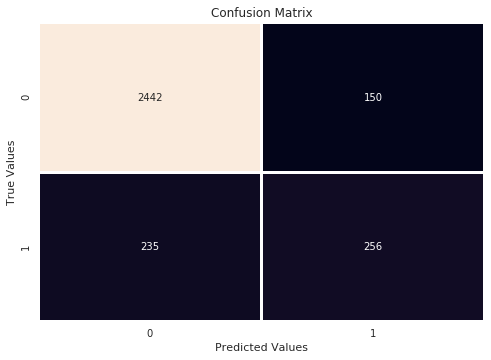

None

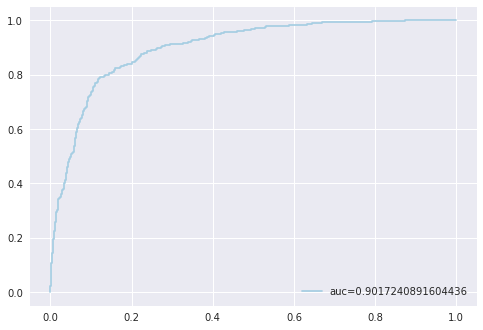

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

lrm_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:

Xlrm = lrm_Xdata.values

#getting the values of our y:
ylrm = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xlrm, ylrm, test_size=0.25, random_state=123)



#building the Logistic regression model 
lrm = LogisticRegression( max_iter = 2000,random_state=123)#,class_weight={0:0.2,1:0.8})#,random_state=123 )#,penalty='l1')
#lrm = LogisticRegressionCV( )
#fit the model
lrm.fit(X_train, y_train)
#predict the model
y_pred=lrm.predict(X_test)
y_pred_train=lrm.predict(X_train)

print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))




confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#print ('confusion_matrix:' )
#print( confusion_matrix)
print("Accuracy:%.4f" % metrics.accuracy_score(y_test, y_pred))
print ("F1 (weighted): %.4f" % f1_score(y_test, y_pred , average='weighted', zero_division = 0))
print("Precision (weighted): %.4f" % metrics.precision_score(y_test, y_pred , average='weighted', zero_division = 0 ))
print("Recall (weighted): %.4f" % metrics.recall_score(y_test, y_pred,  average='weighted'))

roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# roc taking from scikit learn website
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
y_prob = lrm.predict_proba(X_test)

from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(lrm,X_train, y_train, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(lrm,X_train, y_train, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
display(plt.show())



y_pred_proba = lrm.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()





**Model bias for F1 score is .63 which is not ideal for model validation. We also have a high model variance, .032,  of the F1 score.**<br>

### SMOTE for Logistic Regression
We then tried oversampling using **SMOTE** from the **imblearn** package to see if the model will perform better with regards to class one.

Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      2592
           1       0.53      0.79      0.63       491

    accuracy                           0.85      3083
   macro avg       0.74      0.83      0.77      3083
weighted avg       0.89      0.85      0.86      3083

Accuracy:0.8527
F1 (weighted): 0.8639
Precision (weighted): 0.8874
Recall (weighted): 0.8527
AUC 0.8274036829599457
model bias (f1-score): 0.8587276362402606
model variance (f1-score): 0.007664976574311449
model bias (ROC/AUC): 0.9287055876784694
model variance (ROC/AUC): 0.005743816266672725


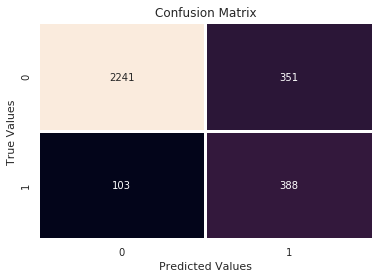

None

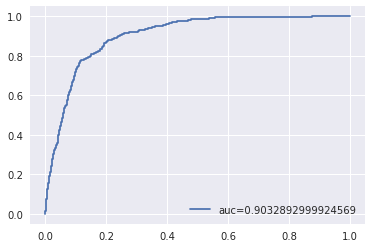

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

lrm_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
Xlrm = lrm_Xdata.values

#getting the values of our y:
ylrm = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xlrm, ylrm, test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

sm =SMOTE()
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

#building the Logistic regression model 
lrm2 = LogisticRegression( max_iter = 2000,random_state=123)#,class_weight={0:0.2,1:0.8})#,random_state=123 )#,penalty='l1')
#lrm = LogisticRegressionCV( )
#fit the model
lrm2.fit(X_train_bal, y_train_bal)
#predict the model
y_pred=lrm2.predict(X_test)
y_pred_train=lrm2.predict(X_train_bal)

print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))




confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#print ('confusion_matrix:' )
#print( confusion_matrix)
print("Accuracy:%.4f" % metrics.accuracy_score(y_test, y_pred))
print ("F1 (weighted): %.4f" % f1_score(y_test, y_pred , average='weighted', zero_division = 0))
print("Precision (weighted): %.4f" % metrics.precision_score(y_test, y_pred , average='weighted', zero_division = 0 ))
print("Recall (weighted): %.4f" % metrics.recall_score(y_test, y_pred,  average='weighted'))

roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# roc taking from scikit learn website
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
y_prob = lrm2.predict_proba(X_test)

from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(lrm2,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(lrm2,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
display(plt.show())



y_pred_proba = lrm2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()



**Looking at the Confusion Matrix, the model with oversampling performed well in predcting class 1 when using all the features. There was an improvement across all metrics relative to the previous testing. <br> Let's try feature selection on top of oversampling <br> Using the SpFtSel package which picked these features :** <br>

```python

best_features_spsa = ['ProductRelated_skew_s', 'TrafficType_dummies_20',
       'OperatingSystems_dummies_8', 'TrafficType_dummies_5',
       'Browser_dummies_12', 'OperatingSystems_dummies_7']

```


## Feature Selection

- Splitting into Testing & Training Data
- Pre-Modeling step of which and how many features to  select
- Determine what will be used for the cross-validation process

Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.96      0.88      0.91      2592
           1       0.55      0.79      0.65       491

    accuracy                           0.86      3083
   macro avg       0.75      0.83      0.78      3083
weighted avg       0.89      0.86      0.87      3083

Accuracy:0.8628
F1 (weighted): 0.8722
Precision (weighted): 0.8916
Recall (weighted): 0.8628
AUC 0.8333836212315506
model bias (f1-score): 0.8455970682200535
model variance (f1-score): 0.009524781082305946
model bias (ROC/AUC): 0.8837048706584761
model variance (ROC/AUC): 0.0076381155480034


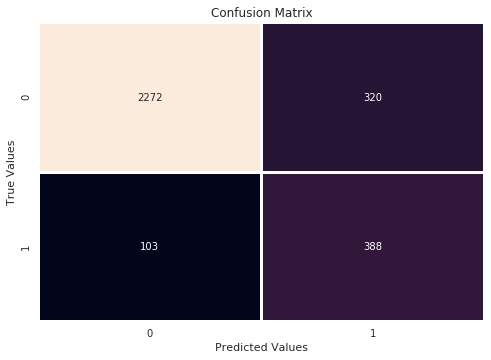

None

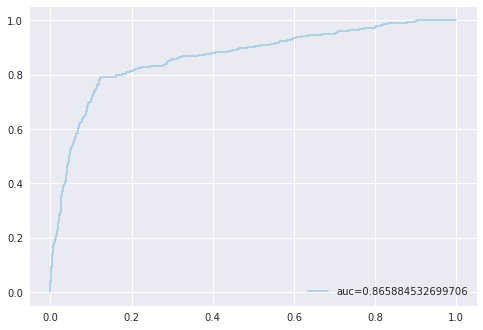

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
#best_features_spsa = ['ProductRelated_skew_s', 'TrafficType_dummies_20',
#       'OperatingSystems_dummies_8', 'TrafficType_dummies_5',
#       'Browser_dummies_12', 'OperatingSystems_dummies_7']
lrm_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
Xlrm = lrm_Xdata[best_features_spsa].values
#Xlrm= lrm_Xdata[clos_1].values
#Xlrm = lrm_Xdata.values

#getting the values of our y:
ylrm = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xlrm, ylrm, test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
#sm =ADASYN(n_neighbors=20)
sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

#building the Logistic regression model 
lrm3 = LogisticRegression( max_iter = 2000,random_state=123 , C=1.0, dual=False)#,class_weight={0:0.2,1:0.8})#,random_state=123 )#,penalty='l1')
#lrm = LogisticRegressionCV( )
#fit the model
lrm3.fit(X_train_bal, y_train_bal)
#predict the model
y_pred=lrm3.predict(X_test)
y_pred_train=lrm3.predict(X_train_bal)

print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))




confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
#print ('confusion_matrix:' )
#print( confusion_matrix)
print("Accuracy:%.4f" % metrics.accuracy_score(y_test, y_pred))
print ("F1 (weighted): %.4f" % f1_score(y_test, y_pred , average='weighted', zero_division = 0))
print("Precision (weighted): %.4f" % metrics.precision_score(y_test, y_pred , average='weighted', zero_division = 0 ))
print("Recall (weighted): %.4f" % metrics.recall_score(y_test, y_pred,  average='weighted'))

roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# roc taking from scikit learn website
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings
y_prob = lrm3.predict_proba(X_test)

from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(lrm3,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(lrm3,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())



sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
display(plt.show())



y_pred_proba = lrm3.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.show()
 



**When applying feature selection, the model perform did not perform better for class 1 but not by much and performed worse for class 0. We have a bias of .84 and AUC of .88 and .007 for the variance. Other model it is .86, whichh is higher and have a .0096 bias with a higher AUC. Our model performed lower than expected when we used feature selection. We have determined that the package has given us a good start with this model, or we need to do a better job of feature selection**




# 2- Naive Bayes model :
-  No hyperparameters 
-  With oversampling
-  With oversampling and feature selection

AUC 0.7322326569611024
Accuracy: 0.8537139150178398
Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2592
           1       0.54      0.55      0.55       491

    accuracy                           0.85      3083
   macro avg       0.73      0.73      0.73      3083
weighted avg       0.86      0.85      0.85      3083

model bias (f1-score): 0.5764820019292225
model variance (f1-score): 0.033292101177834044
model bias (ROC/AUC): 0.8954902276525618
model variance (ROC/AUC): 0.009466019313726093


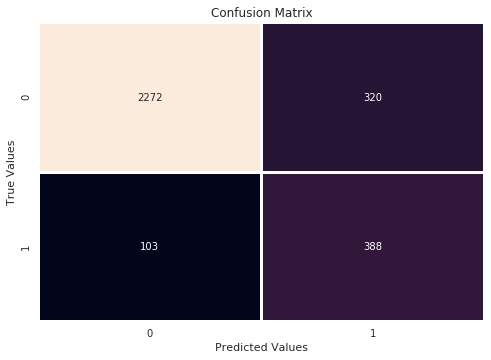

None

In [ ]:
#Import Gaussian Naive Bayes model
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#Create a Gaussian Classifier

gnb_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xlrm = lrm_Xdata[best_features_spsa].values
#X_gnb= gnb_Xdata[clos_1].values
X_gnb = gnb_Xdata.values

#getting the values of our y:
y_gnb = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(X_gnb, y_gnb , test_size=0.25, random_state=123)




gnb = BernoulliNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)
from sklearn import metrics
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))


y_prob = gnb.predict_proba(X_test)


from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gnb,X_train, y_train, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gnb,X_train, y_train, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())

sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
display(plt.show())

**Model bias for F1 score is .57 which is not ideal for model validation. We also have a high model variance, .033,  of the F1 score.**<br>



###  Model#2-b: With oversampling

AUC 0.7995272937567574
Accuracy: 0.818358741485566
Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      2592
           1       0.46      0.77      0.58       491

    accuracy                           0.82      3083
   macro avg       0.70      0.80      0.73      3083
weighted avg       0.87      0.82      0.84      3083

model bias (f1-score): 0.8768834536516827
model variance (f1-score): 0.007859407550031462
model bias (ROC/AUC): 0.9334453164515076
model variance (ROC/AUC): 0.004797488741604819


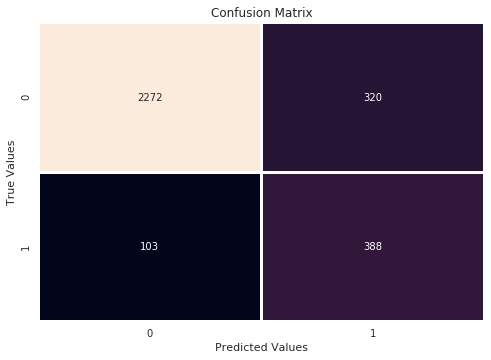

None

In [ ]:
#Import Gaussian Naive Bayes model
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#Create a Gaussian Classifier

gnb_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xlrm = lrm_Xdata[best_features_spsa].values
#X_gnb= gnb_Xdata[clos_1].values
X_gnb = gnb_Xdata.values

#getting the values of our y:
y_gnb = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(X_gnb, y_gnb , test_size=0.25, random_state=123)


from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

gnb2 = BernoulliNB()

#Train the model using the training sets
gnb2.fit(X_train_bal, y_train_bal)

#Predict the response for test dataset
y_pred = gnb2.predict(X_test)
from sklearn import metrics
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))


y_prob = gnb2.predict_proba(X_test)

from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gnb2,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gnb2,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
display(plt.show())

**Looking at the Confusion Matrix, the model with oversampling performed well in predcting class 1 when using all the features. There was an improvement across all metrics relative to the previous testing. <br> Let's try feature selection on top of oversampling <br> Using the SpFtSel package which picked these features :** <br>



### mdoel #2-c: With oversampling and feature selection

AUC 0.8333836212315506
Accuracy: 0.8627959779435614
Classification Report for Classfier Test:
              precision    recall  f1-score   support

           0       0.96      0.88      0.91      2592
           1       0.55      0.79      0.65       491

    accuracy                           0.86      3083
   macro avg       0.75      0.83      0.78      3083
weighted avg       0.89      0.86      0.87      3083

model bias (f1-score): 0.8468734579848187
model variance (f1-score): 0.00860811686163394
model bias (ROC/AUC): 0.8605136996235033
model variance (ROC/AUC): 0.007273141705986575


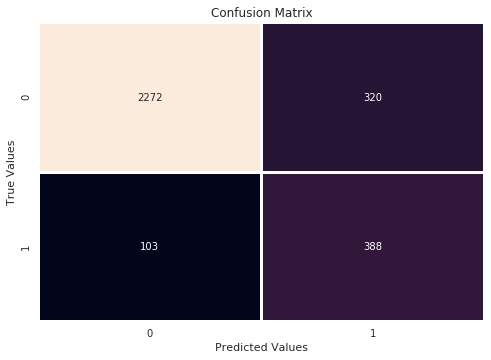

In [ ]:
#Import Gaussian Naive Bayes model
#from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
#Create a Gaussian Classifier

gnb_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
X_gnb = gnb_Xdata[best_features_spsa].values
#X_gnb= gnb_Xdata[clos_1].values
#X_gnb = gnb_Xdata.values

#getting the values of our y:
y_gnb = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(X_gnb, y_gnb , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

gnb3 = BernoulliNB()

#Train the model using the training sets
gnb3.fit(X_train_bal, y_train_bal)

#Predict the response for test dataset
y_pred = gnb3.predict(X_test)
from sklearn import metrics
roc_auc = roc_auc_score(y_test, y_pred)
print('AUC' ,roc_auc)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Classification Report for Classfier Test:')
print(classification_report(y_test, y_pred , zero_division = 0))


y_prob = gnb3.predict_proba(X_test)

from sklearn.model_selection import cross_val_score, RepeatedKFold

rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(gnb3,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(gnb3,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())




sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

__There's no change between the models when applying feature selection__

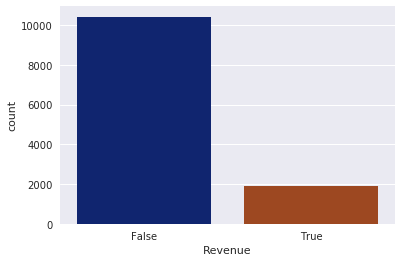

In [ ]:
sns.countplot(df['Revenue'], palette='dark')
#df["Revenue"].value_counts()[1]/df.shape[0]

# 3- DecisionTreeClassifier :
- Simple
- With oversampling 
- With oversampling and feature selection


In [ ]:
#Without oversampling

from sklearn.tree import DecisionTreeClassifier

dt_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xdt = dt_Xdata[best_features_spsa].values
#Xdt= dt_Xdata[cols_2].values
Xdt = dt_Xdata.values

#getting the values of our y:
y_dt = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xdt, y_dt , test_size=0.25, random_state=123)



dt = DecisionTreeClassifier(max_depth=3 )

dt.fit(X_train, y_train)

dt_train_pred2 = dt.predict(X_train)

dt_test_pred2 = dt.predict(X_test)

from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Training Metrics")
print("Accuracy:",accuracy_score(y_train,dt_train_pred2  ))
print("Precision:",precision_score(y_train,dt_train_pred2, zero_division = 0))
print("Recall:",recall_score(y_train,dt_train_pred2, zero_division = 0))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,dt_test_pred2))
print("Precision:",precision_score(y_test,dt_test_pred2 , zero_division = 0))
print("Recall:",recall_score(y_test,dt_test_pred2, zero_division = 0))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,dt_test_pred2, zero_division = 0))

from sklearn.metrics import roc_curve, auc
roc_auc = roc_auc_score(y_test, dt_test_pred2)
print('AUC' ,roc_auc)




rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(dt,X_train, y_train, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(dt,X_train, y_train, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())







Training Metrics
Accuracy: 0.8981291229587974
Precision: 0.6652748782185108
Recall: 0.6746647847565279
Test Metrics
Accuracy: 0.8790139474537788
Precision: 0.6170634920634921
Recall: 0.6334012219959266
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2592
           1       0.62      0.63      0.63       491

    accuracy                           0.88      3083
   macro avg       0.77      0.78      0.78      3083
weighted avg       0.88      0.88      0.88      3083

AUC 0.7794706727263584
model bias (f1-score): 0.6398542583377341
model variance (f1-score): 0.04239684449259821
model bias (ROC/AUC): 0.9149815043285804
model variance (ROC/AUC): 0.007920844522886501


In [ ]:
#With oversampling

from sklearn.tree import DecisionTreeClassifier

dt_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xdt = dt_Xdata[best_features_spsa].values
#Xdt= dt_Xdata[cols_2].values
Xdt = dt_Xdata.values

#getting the values of our y:
y_dt = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xdt, y_dt , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

dt2 = DecisionTreeClassifier(max_depth=3 )

dt2.fit(X_train_bal, y_train_bal)

dt_train_pred2 = dt2.predict(X_train_bal)

dt_test_pred2 = dt2.predict(X_test)

from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,dt_train_pred2 , ))
print("Precision:",precision_score(y_train_bal,dt_train_pred2, zero_division = 0))
print("Recall:",recall_score(y_train_bal,dt_train_pred2, zero_division = 0))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,dt_test_pred2))
print("Precision:",precision_score(y_test,dt_test_pred2 , zero_division = 0))
print("Recall:",recall_score(y_test,dt_test_pred2, zero_division = 0))

roc_auc = roc_auc_score(y_test, dt_test_pred2)
print('AUC' ,roc_auc)
from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,dt_test_pred2, zero_division = 0))

from sklearn.metrics import roc_curve, auc






rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(dt2,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(dt2,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())






Training Metrics
Accuracy: 0.8841634738186462
Precision: 0.8974630021141649
Recall: 0.8674329501915709
Test Metrics
Accuracy: 0.8683100875770353
Precision: 0.5635276532137519
Recall: 0.7678207739307535
AUC 0.8275832264715497
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2592
           1       0.56      0.77      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.88      3083

model bias (f1-score): 0.881540430974903
model variance (f1-score): 0.008203430982418243
model bias (ROC/AUC): 0.9393051733508461
model variance (ROC/AUC): 0.006011953632175408


In [ ]:
#With oversampling and feature selection

from sklearn.tree import DecisionTreeClassifier

dt_Xdata = df_X.copy() #making our X columns

best_features_dt = [  
     'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s' ,'VisitorType_dummies_New_Visitor',
 'Weekend_binary']
#getting the values of our x features:
Xdt = dt_Xdata[best_features_spsa].values
Xdt= dt_Xdata[best_features_dt].values
#Xdt = dt_Xdata.values

#getting the values of our y:
y_dt = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xdt, y_dt , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE()
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


dtc = DecisionTreeClassifier(max_depth=5,min_samples_split=40)

dtc.fit(X_train_bal,y_train_bal)

dt_train_pred3 = dtc.predict(X_train_bal)

dt_test_pred3 = dtc.predict(X_test)

from sklearn.metrics import accuracy_score,precision_score,recall_score

print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,dt_train_pred3))
print("Precision:",precision_score(y_train_bal,dt_train_pred3))
print("Recall:",recall_score(y_train_bal,dt_train_pred3))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,dt_test_pred3))
print("Precision:",precision_score(y_test,dt_test_pred3))
print("Recall:",recall_score(y_test,dt_test_pred3))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,dt_test_pred3))
#print('Test Classification Report')
#print(classification_report(y_train_bal,dt_train_pred3))
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, dt_test_pred3)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)

y_prob = dtc.predict_proba(X_test)



rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(dtc,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(dtc,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)


print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())

Training Metrics
Accuracy: 0.8514687100893997
Precision: 0.8857583403420242
Recall: 0.8070242656449553
Test Metrics
Accuracy: 0.866039571845605
Precision: 0.5561959654178674
Recall: 0.7861507128309573
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2592
           1       0.56      0.79      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.87      3083

Roc -Auc Curve 0.8336617761685651
model bias (f1-score): 0.8420382018284132
model variance (f1-score): 0.008473031976630933
model bias (ROC/AUC): 0.899141014317276
model variance (ROC/AUC): 0.006642744597457691


__changeing the hyperparameters to max_depth=5,min_samples_split=40 and doing feature selection gave us the best model.__

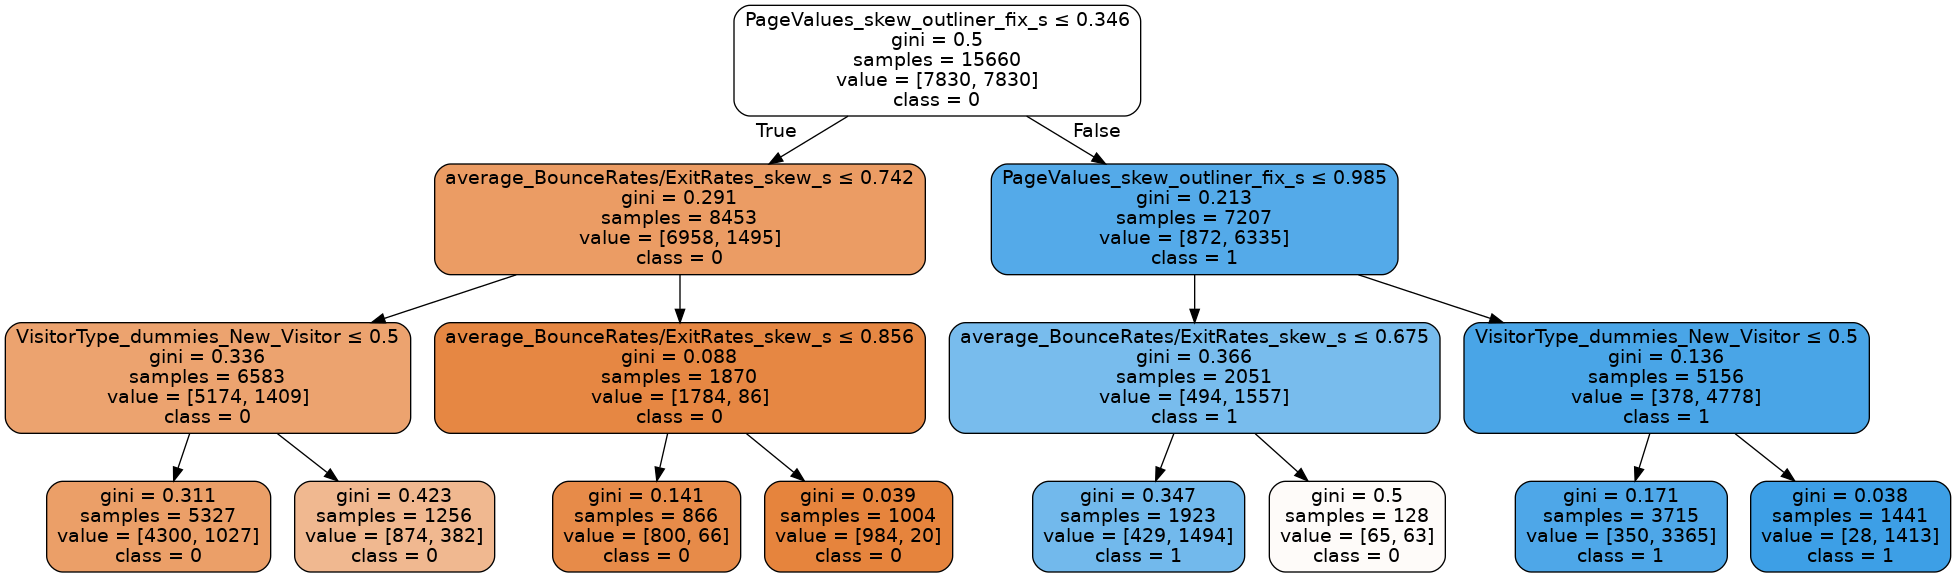

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dtc, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names =best_features_dt,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('shopper_tree.png')
Image(graph.create_png())